# 03-01: Mutli-Threshold for F1

The core idea is to first do a global threshold to optimize the F1 score. Then leave all the samples classified as 0 in place, and do a second threshold to optimize the F1 score for the samples classified as 1.


In [1]:
import sys
import logging
from typing import Iterable, List, Tuple, Dict

import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from pycaret.classification import *
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### Configure Logging

In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-21 14:36:55 INFO     Started


## Data Collection

In [4]:
dtypes = {
    "session_id": np.int64,
    "elapsed_time": np.int32,
    "event_name": "category",
    "name": "category",
    "level": np.uint8,
    "page": "category",
    "room_coor_x": np.float32,
    "room_coor_y": np.float32,
    "screen_coor_x": np.float32,
    "screen_coor_y": np.float32,
    "hover_duration": np.float32,
    "text": "category",
    "fqid": "category",
    "room_fqid": "category",
    "text_fqid": "category",
    "fullscreen": "category",
    "hq": "category",
    "music": "category",
    "level_group": "category",
}

In [5]:
# load the source training set
df_source = pd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=dtypes)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [6]:
# load the source training labels
df_source_labels = pd.read_csv('../data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [7]:
def map_question_to_level_group(question_number) ->str:
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

In [8]:
def find_problem_sessions(data : pd.DataFrame) -> List[str]:
    """
    Finds the sessions that are duplicated on session_id and index. And
    Find sessions with reversed indexes.

    This idea is taken from the following Kaggle notebook:
    https://www.kaggle.com/code/abaojiang/eda-on-game-progress/notebook?scriptVersionId=120133716
    
    Parameters
    ----------
    data : pd.DataFrame
        The data to search.

    Returns
    -------
    List[str]
        The list of session ids that have a problem.
    """

    # find sessions duplicated on session_id and index
    sessions_with_duplicates = df_source.loc[
        data.duplicated(subset=["session_id", "index"], keep=False)] \
        ["session_id"].unique().tolist()


    # find sessions with reversed indexes
    sessions_with_reversed_index = []
    for sess_id, gp in df_source.groupby("session_id", observed=True):
        if not gp["index"].is_monotonic_increasing:
            sessions_with_reversed_index.append(sess_id)

    # via experimentation these sessions have been found to have time 
    # differences < -2000
    negative_time_diff_sessions = [
        '21030417085341900', '21070111080982292', 
        '21090108302064196', '21090409222921812']

    # combine the two lists into a single set
    return set(sessions_with_duplicates + 
               sessions_with_reversed_index + 
               negative_time_diff_sessions)

In [9]:
def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'] \
        .apply(map_question_to_level_group) 
        
    return df_labels

In [10]:
def prepare_main_dataset(data : pd.DataFrame,
                         elapsed_time_min_clip:int=0,
                         elapsed_time_max_clip:int=3691298) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)
    
   # clip the elapsed time to remove outliers
    df_main['elapsed_time'] = df_main['elapsed_time'].clip(
        lower=elapsed_time_min_clip,
        upper=elapsed_time_max_clip)
    
    return df_main

### Process the Data

In [11]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source, 
                                 elapsed_time_min_clip=0,
                                 elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13019794, 14)


,session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,-413.991394,-159.314682,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,-413.991394,-159.314682,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,-413.991394,-159.314682,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [12]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'] \
    .isin(problem_sessions)]

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
172317,21070319253640464,15,0,13-22
194865,21040512553883790,17,1,13-22
197728,22000108514966796,17,1,13-22


## Feature Engineering

### Functions

In [13]:
def create_initial_features(X:pd.DataFrame,
                            y:pd.DataFrame) -> pd.DataFrame:
    """
    Creates the initial dataset to which additional features 
    will be added.

    Parameters
    ----------
    X : pd.DataFrame
        The main dataset.
    y : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The initial feature dataset.
    """
    df_features =  y \
        .groupby(['session_id', 'level_group']) \
        .agg({'correct': ['count']}) \
        .reset_index() \
        .droplevel(1, axis=1) \
        .drop(columns=['correct']) \
        .sort_values(['session_id', 'level_group']) \
        
    # set the session_id to be an integer
    df_features['session_id'] = df_features['session_id'].astype(int)
        
    return df_features        

In [14]:
def add_numeric_column_features(features:pd.DataFrame,
                                X:pd.DataFrame,
                                column:str,
                                min_values:dict=None,
                                max_values:dict=None) -> pd.DataFrame:
    """
    Add the maximum elapsed time feature to the features dataset.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset.
    X : pd.DataFrame
        The main dataset.
    column : str
        The name of the numeric column to add to the features for.

    Returns
    -------
    None
    """
    # Define a function to calculate mode
    def mode(series):
        return series.mode().iat[0]

    # calculate the maximum, minimum and mean for the column
    df_result = X \
        .groupby(['session_id', 'level_group']) \
        .agg({column: ['sum', 'max', 'min', 'mean', mode]}) \
        .reset_index()
    
    # flatten the multi-index columns
    df_result.columns = [
        '_'.join(col).rstrip('_') for col in df_result.columns.values
    ]

    # normalize the values
    if min_values is None or max_values is None:
        logging.warning('Not normalizing the values, min_value and max_values are not set.')
    else:
        metric_list = ['sum', 'max', 'min', 'mean', 'mode']
        for metric in metric_list:
            current_column = f'{column}_{metric}'
            df_result[current_column] = \
                (df_result[current_column] - min_values[metric]) / \
                (max_values[metric] - min_values[metric])       

    # join the features to the result   
    df_result = features.set_index(['session_id', 'level_group']) \
        .join(df_result.set_index(['session_id', 'level_group']), how='left') \
        .reset_index()
    
    return df_result

### Create Features

#### Initial Features

In [15]:
# create the initial features
df_features = create_initial_features(df_source, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group
0,20090312431273200,0-4
1,20090312431273200,13-22
2,20090312431273200,5-12
3,20090312433251036,0-4
4,20090312433251036,13-22
5,20090312433251036,5-12


#### Elapsed Time

In [16]:
# add the elapsed time features to the features dataset
df_features = add_numeric_column_features(
    features=df_features,
    X=df_source,
    column='elapsed_time',
    min_values={
        'sum': 61395.0,
        'max':  990.0,
        'min':  0.0,
        'mean': 526.447,
        'mode': 0.0},
    max_values={
        'sum':  9990648000,
        'max':  3691298.0,
        'min':  3691298.0,
        'mean': 3691298.0,
        'mode': 3691298.0})

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002
3,20090312433251036,0-4,0.001352,0.063074,0.000000,0.026311,0.000000
4,20090312433251036,13-22,0.324157,1.000000,0.318718,0.676403,1.000000
5,20090312433251036,5-12,0.021933,0.221287,0.072301,0.150206,0.072301


## Data Selection

### Functions

In [17]:
def select_sessions(
        y: pd.DataFrame,
        random_state: int=1337,
        test_size: float=0.2,
        train_size:float=0.6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Select samples from the dataset for training, validation and testing.
    The test set is selected first, then the training set is selected 
    from the remaining sessions. And finally the validation set is 
    selected from the remaining sessions.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    random_state : int
        The random state to use.
    test_size : float
        The ratio of the sample to use for testing.
    train_size : float
        The ratio of the sample to use for training.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # set the random seed
    np.random.seed(random_state)

    # shuffle the session ids
    np.random.shuffle(all_session_ids)

    # select the session ids for the test set
    test, remainder = train_test_split(all_session_ids, test_size=1-test_size)

    # split the dataset into train and validation sets
    train, val = train_test_split(remainder, test_size=1-train_size)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

In [18]:
def get_features_with_labels(features:pd.DataFrame,
                            y:pd.DataFrame) -> pd.DataFrame:
    """
    Create a complete dataset where the label dataset containing the
    target variable is joint to the features dataset.
    """
    return y.join(features.set_index(['session_id', 'level_group']),
                    on=['session_id', 'level_group'],
                    how='left')

### Create Datasets

In [19]:
random_state = 51

In [20]:
# split the dataset into train, validation and test sets
train, val, test = select_sessions(
    y=df_source_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


In [21]:
# get the prepared dataset
features_with_labels = get_features_with_labels(df_features, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(features_with_labels.head(6))

,session_id,question_num,correct,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode
0,20090312431273200,1,1,0-4,0.001411,0.052535,0.0,0.023103,0.0
1,20090312433251036,1,0,0-4,0.001352,0.063074,0.0,0.026311,0.0
2,20090314121766812,1,1,0-4,0.002928,0.106324,0.0,0.047996,0.0
3,20090314363702160,1,1,0-4,0.001627,0.058690,0.0,0.030143,0.0
4,20090314441803444,1,1,0-4,0.000824,0.047682,0.0,0.020862,0.0
5,20090315081004164,1,0,0-4,0.002515,0.092231,0.0,0.036151,0.0


In [22]:
# get the features for the train, validation and test datasets
df_train = features_with_labels[features_with_labels['session_id'].isin(train)] \
    .drop(columns=['session_id', 'level_group'])

df_val = features_with_labels[features_with_labels['session_id'].isin(val)] \
    .drop(columns=['session_id', 'level_group'])
    
df_test = features_with_labels[features_with_labels['session_id'].isin(test)] \
    .drop(columns=['session_id', 'level_group'])

In [23]:
print('Train      :', df_train.shape)
print('Validation :', df_val.shape)
print('Test       :', df_test.shape)

Train      : (62910, 7)
Validation : (20970, 7)
Test       : (125784, 7)


In [24]:
with pd.option_context('display.max_columns', None):
    display(df_train.head(6))

,question_num,correct,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode
1,1,0,0.001352,0.063074,0.0,0.026311,0.0
4,1,1,0.000824,0.047682,0.0,0.020862,0.0
5,1,0,0.002515,0.092231,0.0,0.036151,0.0
9,1,0,0.002094,0.088831,0.0,0.037267,0.0
10,1,1,0.006778,0.223300,0.0,0.077021,0.0
13,1,1,0.002453,0.085622,0.0,0.039016,0.0


## Model Training

### Functions

In [25]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            #print(f'new best f1: {f1}, threshold: {threshold}, precision: {precision}, recall: {recall}')
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall, best_f1

### Train Models

In [26]:
classifier = setup(
    data=df_train,
    target='correct',
    test_data=df_val,
    session_id=random_state,
    fix_imbalance=True,
    fix_imbalance_method='RandomOverSampler',
    use_gpu=False,
    html=True,
    verbose=True)

,Description,Value
0,Session id,51
1,Target,correct
2,Target type,Binary
3,Original data shape,"(83880, 7)"
4,Transformed data shape,"(109686, 7)"
5,Transformed train set shape,"(88716, 7)"
6,Transformed test set shape,"(20970, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [27]:
top_model = compare_models(n_select=15, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.6665,0.7181,0.8666,0.7194,0.7834,0.0617,0.0744,0.0310
nb,Naive Bayes,0.5915,0.6820,0.6963,0.7309,0.6365,0.0447,0.0771,0.0360
lda,Linear Discriminant Analysis,0.5782,0.6702,0.6078,0.7426,0.5808,0.1175,0.1382,0.0350
lr,Logistic Regression,0.5776,0.6693,0.6064,0.7434,0.5800,0.1174,0.1390,0.1660
dummy,Dummy Classifier,0.2949,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0170
dt,Decision Tree Classifier,0.3792,0.3329,0.4459,0.5472,0.4495,-0.2691,-0.2924,0.0520
rf,Random Forest Classifier,0.3827,0.3273,0.4425,0.5652,0.4398,-0.2566,-0.2872,0.4850
et,Extra Trees Classifier,0.3981,0.3162,0.4788,0.5652,0.4803,-0.2610,-0.2833,0.4790
ada,Ada Boost Classifier,0.3345,0.3077,0.3526,0.3394,0.3196,-0.2604,-0.3576,0.2210
gbc,Gradient Boosting Classifier,0.3273,0.2751,0.3561,0.3272,0.3238,-0.2837,-0.3685,0.8000


### Select a Target Model

Plot the evaluation metrics for the target model and pick the model with the best macro average F1 score.

In [28]:
for model in top_model:
    df_predicted = predict_model(estimator=model, data=df_test)
    print(classification_report(y_true=df_predicted.correct, y_pred=df_predicted.prediction_label))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.6654,0.6193,0.8655,0.7169,0.7843,0.0671,0.0734


              precision    recall  f1-score   support

           0       0.38      0.19      0.25     37388
           1       0.72      0.87      0.78     88396

    accuracy                           0.67    125784
   macro avg       0.55      0.53      0.52    125784
weighted avg       0.62      0.67      0.63    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6030,0.5862,0.7158,0.7183,0.7170,0.0518,0.0518


              precision    recall  f1-score   support

           0       0.33      0.34      0.33     37388
           1       0.72      0.72      0.72     88396

    accuracy                           0.60    125784
   macro avg       0.53      0.53      0.53    125784
weighted avg       0.60      0.60      0.60    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.5865,0.5955,0.6148,0.7516,0.6764,0.1196,0.1243


              precision    recall  f1-score   support

           0       0.36      0.52      0.43     37388
           1       0.75      0.61      0.68     88396

    accuracy                           0.59    125784
   macro avg       0.56      0.57      0.55    125784
weighted avg       0.64      0.59      0.60    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5876,0.5965,0.6166,0.7520,0.6776,0.1209,0.1255


              precision    recall  f1-score   support

           0       0.36      0.52      0.43     37388
           1       0.75      0.62      0.68     88396

    accuracy                           0.59    125784
   macro avg       0.56      0.57      0.55    125784
weighted avg       0.64      0.59      0.60    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Dummy Classifier,0.2972,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


              precision    recall  f1-score   support

           0       0.30      1.00      0.46     37388
           1       0.00      0.00      0.00     88396

    accuracy                           0.30    125784
   macro avg       0.15      0.50      0.23    125784
weighted avg       0.09      0.30      0.14    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.6582,0.5912,0.7566,0.7569,0.7568,0.1820,0.1820


              precision    recall  f1-score   support

           0       0.43      0.43      0.43     37388
           1       0.76      0.76      0.76     88396

    accuracy                           0.66    125784
   macro avg       0.59      0.59      0.59    125784
weighted avg       0.66      0.66      0.66    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7007,0.7139,0.8055,0.7768,0.7909,0.2650,0.2656


              precision    recall  f1-score   support

           0       0.50      0.45      0.47     37388
           1       0.78      0.81      0.79     88396

    accuracy                           0.70    125784
   macro avg       0.64      0.63      0.63    125784
weighted avg       0.69      0.70      0.70    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7148,0.7111,0.8604,0.7637,0.8092,0.2527,0.2599


              precision    recall  f1-score   support

           0       0.53      0.37      0.44     37388
           1       0.76      0.86      0.81     88396

    accuracy                           0.71    125784
   macro avg       0.65      0.62      0.62    125784
weighted avg       0.69      0.71      0.70    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,str,0.6385,0.7381,0.5995,0.8404,0.6998,0.2762,0.3018


              precision    recall  f1-score   support

           0       0.44      0.73      0.55     37388
           1       0.84      0.60      0.70     88396

    accuracy                           0.64    125784
   macro avg       0.64      0.67      0.62    125784
weighted avg       0.72      0.64      0.65    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6670,0.7517,0.6521,0.8381,0.7335,0.3076,0.3252


              precision    recall  f1-score   support

           0       0.46      0.70      0.56     37388
           1       0.84      0.65      0.73     88396

    accuracy                           0.67    125784
   macro avg       0.65      0.68      0.64    125784
weighted avg       0.73      0.67      0.68    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.6346,0.6700,0.6509,0.7921,0.7146,0.2202,0.2286


              precision    recall  f1-score   support

           0       0.42      0.60      0.49     37388
           1       0.79      0.65      0.71     88396

    accuracy                           0.63    125784
   macro avg       0.61      0.62      0.60    125784
weighted avg       0.68      0.63      0.65    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6788,0.7555,0.6772,0.8346,0.7477,0.3188,0.3322


              precision    recall  f1-score   support

           0       0.47      0.68      0.56     37388
           1       0.83      0.68      0.75     88396

    accuracy                           0.68    125784
   macro avg       0.65      0.68      0.65    125784
weighted avg       0.73      0.68      0.69    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.5570,0.5665,0.5430,0.7579,0.6327,0.1114,0.1216


              precision    recall  f1-score   support

           0       0.35      0.59      0.44     37388
           1       0.76      0.54      0.63     88396

    accuracy                           0.56    125784
   macro avg       0.56      0.57      0.54    125784
weighted avg       0.64      0.56      0.58    125784



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.5863,0.5672,0.6142,0.7516,0.6760,0.1195,0.1242


              precision    recall  f1-score   support

           0       0.36      0.52      0.43     37388
           1       0.75      0.61      0.68     88396

    accuracy                           0.59    125784
   macro avg       0.56      0.57      0.55    125784
weighted avg       0.64      0.59      0.60    125784



### Light Gradient Boosting Machine

This looks like a good candidate for the target model.

In [29]:
# create the model
lgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7051,0.6791,1.0000,0.7051,0.8270,0.0008,0.0195
1,0.4913,0.1094,0.6789,0.6290,0.6530,-0.2942,-0.2972
2,0.0892,0.0300,0.0825,0.1807,0.1133,-0.5895,-0.7928
3,0.0612,0.0048,0.0780,0.1600,0.1049,-0.6641,-0.8650
4,0.1135,0.0143,0.1454,0.2653,0.1879,-0.6219,-0.7655
5,0.1739,0.1544,0.2250,0.3620,0.2775,-0.5725,-0.6647
6,0.2882,0.1449,0.0092,0.3306,0.0180,-0.0212,-0.1165
7,0.2950,0.6207,0.0002,1.0000,0.0005,0.0001,0.0082
8,0.1938,0.2109,0.1152,0.3082,0.1677,-0.3505,-0.5207


In [30]:
# evaluate the model on the test set
df_predicted = predict_model(estimator=lgbm_model, data=df_test)
print(classification_report(y_true=df_predicted.correct, y_pred=df_predicted.prediction_label))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6788,0.7555,0.6772,0.8346,0.7477,0.3188,0.3322


              precision    recall  f1-score   support

           0       0.47      0.68      0.56     37388
           1       0.83      0.68      0.75     88396

    accuracy                           0.68    125784
   macro avg       0.65      0.68      0.65    125784
weighted avg       0.73      0.68      0.69    125784



The F1 macro average looks good and similar to what we have seen with previous deep learning experiments.

We shall now try and use the build in method to tune the model for F1 and see if we get a better result.

In [31]:
# attempt to tune the model
tuned_lgbm_model = tune_model(estimator=lgbm_model, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7105,0.6462,1.0000,0.7089,0.8297,0.0264,0.1156
1,0.5536,0.1495,0.7574,0.6598,0.7052,-0.1959,-0.2041
2,0.1397,0.0527,0.1492,0.2878,0.1966,-0.5497,-0.6948
3,0.1822,0.0817,0.2180,0.3659,0.2732,-0.5351,-0.6333
4,0.2537,0.0353,0.3449,0.4610,0.3946,-0.5272,-0.5658
5,0.2985,0.1598,0.4035,0.5032,0.4479,-0.4825,-0.5050
6,0.2685,0.1828,0.1127,0.4288,0.1785,-0.1628,-0.2890
7,0.3103,0.5785,0.0286,0.8089,0.0553,0.0075,0.0364
8,0.2626,0.2529,0.2009,0.4489,0.2775,-0.2809,-0.3816


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [32]:
# evaluate the tuned model on the test set
df_predicted = predict_model(estimator=tuned_lgbm_model, data=df_test)
#print(classification_report(y_true=df_predicted.correct, y_pred=df_predicted.prediction_label))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6741,0.7052,0.7326,0.7887,0.7596,0.2560,0.2577


The Tuned model produce worst results so we will stick to the original.

We will now try to find a threshold that optimizes the F1 score.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6978,0.7842,0.6908,0.8533,0.7635,0.3579,0.3734


Optimized F1: 0.69
Optimized threshold: 0.43


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6788,0.7555,0.6772,0.8346,0.7477,0.3188,0.3322



--- Test evaluation without threshold---
              precision    recall  f1-score   support

           0       0.47      0.68      0.56     37388
           1       0.83      0.68      0.75     88396

    accuracy                           0.68    125784
   macro avg       0.65      0.68      0.65    125784
weighted avg       0.73      0.68      0.69    125784



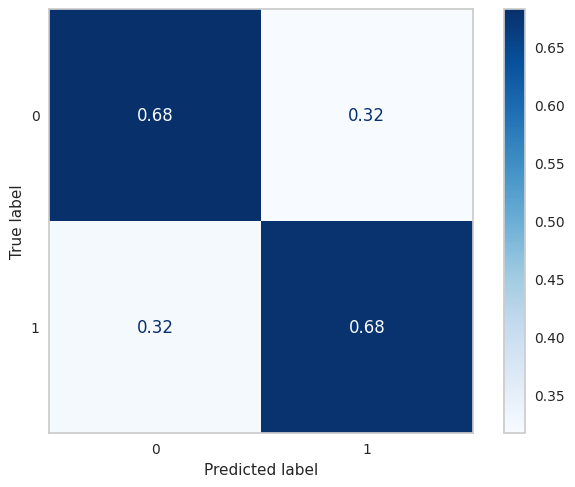


--- Test evaluation WITH threshold---
              precision    recall  f1-score   support

           0       0.52      0.54      0.53     37388
           1       0.80      0.79      0.80     88396

    accuracy                           0.72    125784
   macro avg       0.66      0.67      0.67    125784
weighted avg       0.72      0.72      0.72    125784



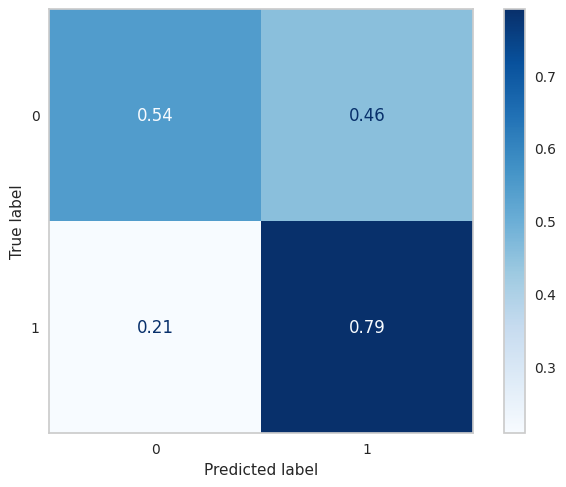

In [33]:
# combine the training and validation sets
df_train_val = pd.concat([df_train, df_val])

# get the predictions
df_predicted = predict_model(estimator=lgbm_model, data=df_train_val, raw_score=True)
y_true = df_predicted.correct
y_score = df_predicted.prediction_score_1

# print()
# print('--- Train and Validation without threshold---')
# print(classification_report(y_true=df_predicted.correct, y_pred=df_predicted.prediction_label))

# print()
# # print('--- Train and Validation WITH threshold---')
# print()
# print(classification_report(y_true=df_predicted.correct, y_pred=(df_predicted.prediction_score_1 > threshold)))

# optimize the F1 score
threshold, precision, recall, f1 = optimize_f1(y_true.values, y_score.values)
print(f'Optimized F1: {f1:.2f}')
print(f'Optimized threshold: {threshold:.2f}')


# evaluate the model on the test set
df_test_predicted = predict_model(estimator=lgbm_model, data=df_test, raw_score=True)
y_true_pred = df_test_predicted.correct

print()
print('--- Test evaluation without threshold---')
print(classification_report(y_true=y_true_pred, y_pred=df_test_predicted.prediction_label))
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_true_pred, 
    y_pred= df_test_predicted.prediction_label,
    cmap=plt.cm.Blues,
    normalize='true')
plt.grid(False)
plt.show()

print()
print('--- Test evaluation WITH threshold---')
y_pred = (df_test_predicted.prediction_score_1 > threshold).astype(int)
print(classification_report(y_true=y_true_pred, y_pred=y_pred))

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_true_pred, 
    y_pred=y_pred,
    cmap=plt.cm.Blues,
    normalize='true')
plt.grid(False)
plt.show()

We observe the following:

1. The original model is better at detecting the negative class (0) than the second model with the optimized f1 threshold. Thus it has a better true negative rate (TNR).
2. Using the threshold for the second model we get a better true positive rate (TPR).

An idea would thus be to do the prediction with the original model, and leave all negative predictions in place. Then do a second prediction with the second model and replace the positive predictions with the second model predictions.

We can in fact try and optimize the F1 score for the second model by only considering the positive predictions and finding the optimal threshold for that.

We start with the training and validation data that was used during training to find the threshold.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6978,0.7842,0.6908,0.8533,0.7635,0.3579,0.3734


Optimized threshold: 0.56
Changed: 10156 out of 83880 (0.12)
              precision    recall  f1-score   support

           0       0.44      0.83      0.58     24665
           1       0.89      0.57      0.69     59215

    accuracy                           0.64     83880
   macro avg       0.67      0.70      0.64     83880
weighted avg       0.76      0.64      0.66     83880



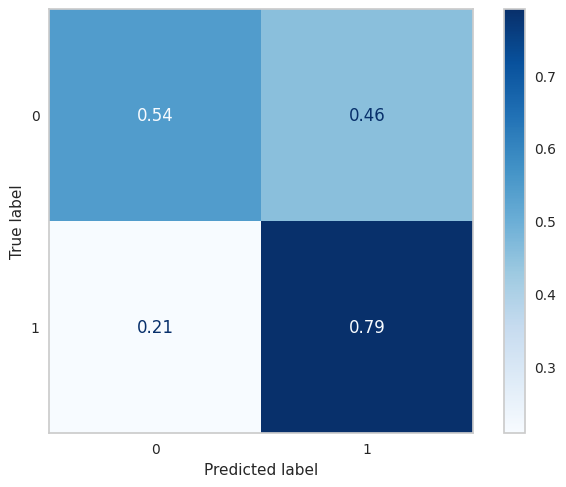

In [34]:
# do predictions with the original model without any threshold
df_predictions = predict_model(estimator=lgbm_model, data=df_train_val, raw_score=True)

# select the rows that was predicted as correct
df_correct = df_predictions[df_predictions['prediction_label'] == 1]

# optimize the F1 score
threshold, precision, recall, f1 = optimize_f1(df_correct.correct.values, df_correct.prediction_score_1.values)
print(f'Optimized threshold: {threshold:.2f}')

# add a final prediction column, if the predicted label is 0, leave it 
# as it is, otherwise apply the threshold
df_predictions['final_prediction'] = df_predictions['prediction_label']
df_predictions.loc[df_predictions['prediction_label'] == 1, 'final_prediction'] = \
    (df_predictions['prediction_score_1'] > threshold).astype(int)

# how many predictions were changes
total = df_predictions.shape[0]
changed_count = df_predictions.query('final_prediction != prediction_label').shape[0]
print(f'Changed: {changed_count} out of {total} ({changed_count / total:.2f})')

# show the results
print(classification_report(y_true=df_predictions.correct, y_pred=df_predictions.final_prediction))

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_true_pred, 
    y_pred=y_pred,
    cmap=plt.cm.Blues,
    normalize='true')
plt.grid(False)
plt.show()

This results in a better f1-score for the negative class, but at the expense of the macro average. What we can try instead if to again leave the zeros in place, and only updates the ones, but the optimizer should consider the whole dataset and not just the ones when finding the threshold.

In [35]:
def special_optimizer(data:pd.DataFrame) -> Tuple[float, float, float, float]:
    """
    Find the best threshold for the F1 score, but only apply it to the 
    rows that was predicted as correct.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0
    df_data = data.copy()

    for threshold in np.arange(0, 1, 0.01):
        df_data['test_prediction'] = df_data['prediction_label']
        df_data.loc[df_data['prediction_label'] == 1, 'test_prediction'] = \
            (df_data['prediction_score_1'] > threshold).astype(int)

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true = df_data.correct,
            y_pred = df_data.test_prediction,
            average='macro', zero_division=1)

        print(f'Current F1 {f1}, best F1: {best_f1}')
        if f1 > best_f1:
            print(f'new best f1: {f1}, threshold: {threshold}, precision: {precision}, recall: {recall}')
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall, best_f1    

# test the function
threshold, precision, recall, f1 = special_optimizer(df_predictions)
print(threshold)        

Current F1 0.672646212353188, best F1: 0
new best f1: 0.672646212353188, threshold: 0.0, precision: 0.671912193017502, recall: 0.7028065720098787
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188
Current F1 0.672646212353188, best F1: 0.672646212353188

As shown this does not lead to any improvement at all since we have already optimized the threshold for the second model.

The next thing to do would be to create individual models for each question, but this has already been done in the Kaggle submissions. We can try it here simply for completeness to see if it leads to any improvement. If so we can take it back to the Deep Learning model work.
